# Wine Quality Dataset - Precise GP

In [33]:
import matplotlib.pyplot as plt # 3.6
import numpy as np # 1.22.4
import tensorflow as tf # 2.11.0
import gpflow # 2.7.0
import pandas as pd
import tensorflow_probability as tfp
from tensorflow import keras
import seaborn as sns
import torch
from tensorflow.python.ops.numpy_ops import np_config
from LambdaRBF import LambdaRBF
from utils import *
import pandas as pd
import os
np_config.enable_numpy_behavior()
plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")
print('tensorflow ', tf.__version__) 
print('pytorch ', torch.__version__) 
print('numpy ', np.__version__) 
print('gpflow ', gpflow.__version__) 
print('pandas ', pd.__version__) 
tf.random.set_seed(42)
np.random.seed(42)

tensorflow  2.11.0
pytorch  1.13.1
numpy  1.22.4
gpflow  2.7.0
pandas  1.5.3


## Import the Wine Dataset

In [34]:
def csv_to_pth(name, csv_path, pth_path):
    def dataframe_to_arrays(df):
        df_ = df.copy(deep=True)
        X = np.atleast_2d(df_[input_cols].to_numpy())
        Y = np.atleast_2d(df_[output_cols].to_numpy().reshape(-1,1))
        return X, Y
    dataframe_raw = pd.read_csv(csv_path)
    dataframe_raw.head()
    input_cols = list(dataframe_raw.columns)[:-1]
    output_cols = list(dataframe_raw.columns)[-1]
    X, Y = dataframe_to_arrays(dataframe_raw)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    inputs = torch.tensor(X, dtype=torch.float64)
    targets = torch.tensor(Y, dtype=torch.float64)
    torch.save([inputs, targets], pth_path + name + '.pth')
    return input_cols, output_cols
input_cols, output_cols = csv_to_pth("wine", "data/winequality-red.csv", "data/")

In [35]:
X_train, Y_train,  X_test, Y_test, Y_train_mean, Y_train_std = create_dataset('wine', 42)
D = X_train.shape[1]

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(66,)",float64,"[0.30151, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
--- Final values ---
Variance: 1.414
Train RMSE (Standardised): 0.648
Test RMSE (Standardised): 0.729


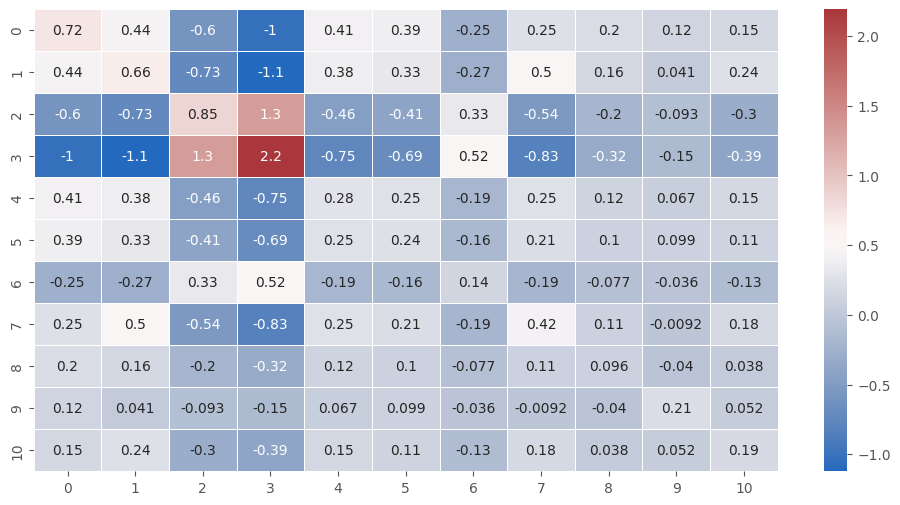

In [37]:
model_GPR_LRBF, _ = train_GPR_LRBF_model(X_train=X_train, Y_train=Y_train, prior=None, iprint=True)
train_rmse_stan, test_rmse_stan = measure_rmse(model_GPR_LRBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(11,)",float64,"[3.31662, 3.31662, 3.31662..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lengthscales:  [3.31662479 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479
 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479]
--- Final values ---
Variance: 0.794
Lengthscales:  [ 2.99344427  5.33099901  2.6843501  10.31257572 41.72945966 10.38448465
  4.66640896 33.7174328   2.95500098  1.40131052  1.60454617]
Train RMSE (Standardised): 0.716
Test RMSE (Standardised): 0.746


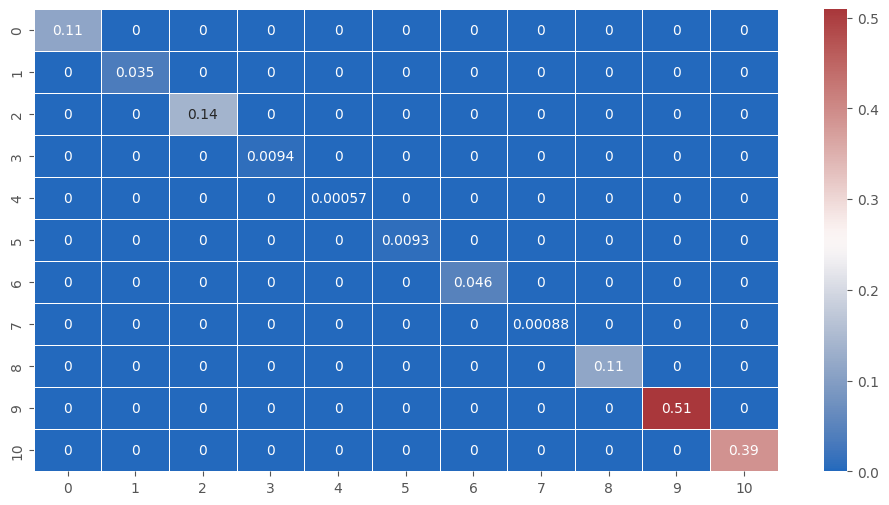

In [36]:
model_GPR_RBF, _ = train_GPR_RBF_model(X_train=X_train, Y_train=Y_train, prior=None, iprint=True)
train_rmse_stan, test_rmse_stan = measure_rmse(model_GPR_RBF, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.Lambda_L,Parameter,Identity,,True,"(66,)",float64,"[0.30151, 0., 0...."
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


--- Initial values ---
Variance: 1.000
Lambda diagonal:  [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
--- Final values ---
Variance: 1.908
Train RMSE (Standardised): 0.689
Test RMSE (Standardised): 0.751


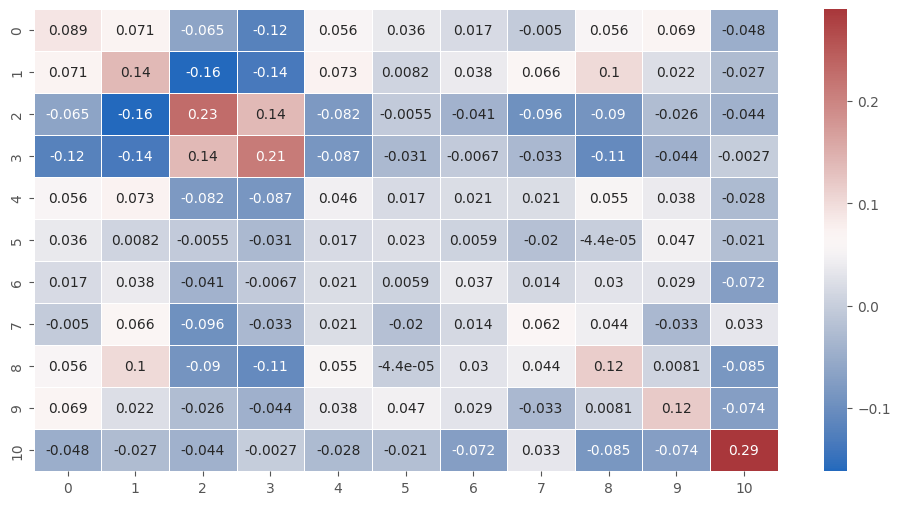

In [41]:
model_GPR_LRBF_reg, _ = train_GPR_LRBF_model(X_train=X_train, Y_train=Y_train, reg=0.1, prior=None, iprint=True)
train_rmse_stan, test_rmse_stan = measure_rmse(model_GPR_LRBF_reg, X_train, Y_train, X_test, Y_test)
print('Train RMSE (Standardised): %.3f'%(train_rmse_stan))
print('Test RMSE (Standardised): %.3f'%(test_rmse_stan))